In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import time

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Pour activer la croissance de la mémoire pour un GPU spécifique
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.set_log_device_placement(True)

1 Physical GPUs, 1 Logical GPUs


# Load Dataset

In [3]:
#we load data
path = ""

path_to_label = "scaled_params_TiPS.csv" #path+"scaled_params_TiPS.csv"
path_to_label2 = "scaled_params_TiPS2.csv"
path_to_input = 'CBLV_TiPS.npy' #path+"CBLV_TiPS.npy
path_to_input2 = 'CBLV_TiPS2.npy'

params_to_infer = ["mean_signal", "amplitude", "incubation_rate", "recovery_rate", "import_param", "sampling_proba"]
# params_to_infer = ["mean_signal", "amplitude", "incubation_rate", "recovery_rate", "sampling_proba"]
nb_estimates = len(params_to_infer)
PROP_TRAIN =  0.98
# PROP_VAL = 0.1

all_inputs = np.transpose(np.load(path_to_input), axes=(0, 2, 1))
all_inputs2 = np.transpose(np.load(path_to_input2), axes=(0, 2, 1))


all_labels = pd.read_csv(path_to_label)[params_to_infer].to_numpy()
all_labels2 = pd.read_csv(path_to_label2)[params_to_infer].to_numpy()

inputs = np.concatenate((all_inputs, all_inputs2), axis=0)
labels = np.concatenate((all_labels, all_labels2), axis=0)
# #Check shapes
print('inputs shape:', all_inputs.shape)
print('labels shape:', all_labels.shape)
print('inputs shape:', all_inputs2.shape)
print('labels shape:', all_labels2.shape)
print("label concatenation: ", labels.shape)
print("input concatenation:", inputs.shape)
# # !!! shuffle before 
num_train = int(labels.shape[0]*PROP_TRAIN)

x_train, y_train = inputs[:num_train, :, :], labels[:num_train, :]
x_val, y_val = inputs[num_train:, :, :], labels[num_train:, :]

train_size = x_train.shape[0]
print(f"There is {train_size} training data, {x_val.shape[0]} validation data")

inputs shape: (141289, 901, 2)
labels shape: (141289, 6)
inputs shape: (202574, 901, 2)
labels shape: (202574, 6)
label concatenation:  (343863, 6)
input concatenation: (343863, 901, 2)
There is 336985 training data, 6878 validation data


# Design models

In [5]:
# size_sm_tree, size_lg_tree = 201, 500

SIZE = 901

# FNN_infer = keras.Sequential(
# [
#     keras.Input(shape=(SIZE,2)),
#     layers.Dense(64, activation="elu"),
#     layers.Dropout(.2),
#     layers.Dense(32, activation="elu"),
#     layers.Dropout(.2),
#     layers.Dense(16, activation="elu"),
#     layers.Dropout(.2),
#     layers.Dense(8, activation="elu"),
# #     layers.Dropout(.5),
#     layers.Flatten(),
#     layers.Dense(nb_estimates, activation="linear")
# ])

# CNN_infer1 = keras.Sequential(
#     [
#         keras.Input(shape=(SIZE, 2)),
#         layers.Conv1D(filters=50, kernel_size=3),   
#         layers.Conv1D(filters=50, kernel_size=10),
#         layers.MaxPooling1D(pool_size=10),
#         layers.Conv1D(filters=80, kernel_size=10),
#         layers.GlobalAveragePooling1D(),
#         layers.Dense(64, activation="elu"),
#         layers.Dropout(.2),
#         layers.Dense(32, activation="elu"),
#         layers.Dropout(.2),
#         layers.Dense(16, activation="elu"),
#         layers.Dropout(.2),
#         layers.Dense(8, activation="elu"),
#         layers.Dropout(.2),
#         layers.Dense(nb_estimates, activation="linear")
#     ]
# )

CNN_infer2 = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=50, kernel_size=3),  ## !! normalement batch normalization puis relu apres conv 
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.Conv1D(filters=50, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=80, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="elu"),
        layers.Dropout(.2),
        layers.Dense(32, activation="elu"),
        layers.Dropout(.2),
        layers.Dense(16, activation="elu"),
        layers.Dropout(.2),
        layers.Dense(8, activation="elu"),
        layers.Dropout(0.0),
        layers.Dense(nb_estimates, activation="linear")
    ]
)

CNN_infer3 = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=70, kernel_size=5),  
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.Conv1D(filters=70, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=90, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(64, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(32, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(16, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(8, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(nb_estimates, activation="linear")
    ]
)

CNN_infer4 = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=70, kernel_size=5),  
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.Conv1D(filters=70, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=90, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(96, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(48, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(24, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(12, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(nb_estimates, activation="linear")
    ]
)

#TEST
inp = tf.random.normal((1, 901,2))

# print("Model 1: FNN_infer...")
# FNN_infer.summary()
# print('out', FNN_infer(inp).shape, '\n')

# print("Model 2: CNN_infer1...")
# CNN_infer1.summary()
# print('out', CNN_infer1(inp).shape, '\n')

print("CNN_infer2...")
CNN_infer2.summary()
print('out', CNN_infer2(inp).shape, '\n')

print("CNN_infer3...")
CNN_infer3.summary()
print('out', CNN_infer3(inp).shape, '\n')

print("CNN_infer4...")
CNN_infer4.summary()
print('out', CNN_infer4(inp).shape, '\n')

CNN_infer2...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 899, 50)           350       
_________________________________________________________________
batch_normalization_9 (Batch (None, 899, 50)           200       
_________________________________________________________________
activation_9 (Activation)    (None, 899, 50)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 890, 50)           25050     
_________________________________________________________________
batch_normalization_10 (Batc (None, 890, 50)           200       
_________________________________________________________________
activation_10 (Activation)   (None, 890, 50)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 89, 

# Training 

In [6]:
def training(model, batch_size=400, num_epochs = 10000, patience=100, min_diff=0.5):
    
    custom_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=min_diff, patience=patience)
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanAbsolutePercentageError(),
    )
    
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=num_epochs, callbacks=[custom_early_stop]);
    
    return history

## *Plot learning curves*

In [7]:
def plot_curves(name_model, history):
    num_real_epochs = len(history.history['loss'])
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure()
    plt.plot(np.arange(num_real_epochs), train_loss, '-r', label="Training loss")
    plt.plot(np.arange(num_real_epochs), val_loss, '-g', label="Validation loss")
    plt.xlabel('epoch')
    plt.legend()
    plt.title(name_model+": Learning curves for parameters inference")
    
#     plt.figure()
#     plt.plot(np.arange(1,num_real_epochs), train_loss[1:], '-r', label="Training loss")
#     plt.plot(np.arange(1,num_real_epochs), val_loss[1:], '-g', label="Validation loss")
#     plt.xlabel('epoch')
#     plt.legend()
    
    plt.show()

## *Compare models*

Epoch 1/10000
422/422 [==============================] - 18s 40ms/step - loss: 83.6209 - val_loss: 48.6716
Epoch 2/10000
422/422 [==============================] - 16s 37ms/step - loss: 42.6853 - val_loss: 38.3433
Epoch 3/10000
422/422 [==============================] - 16s 37ms/step - loss: 38.2763 - val_loss: 37.0027
Epoch 4/10000
422/422 [==============================] - 16s 37ms/step - loss: 35.6857 - val_loss: 33.4444
Epoch 5/10000
422/422 [==============================] - 16s 37ms/step - loss: 34.2252 - val_loss: 33.1836
Epoch 6/10000
422/422 [==============================] - 16s 37ms/step - loss: 33.5618 - val_loss: 32.8208
Epoch 7/10000
422/422 [==============================] - 16s 37ms/step - loss: 33.1378 - val_loss: 31.8603
Epoch 8/10000
422/422 [==============================] - 16s 37ms/step - loss: 32.7481 - val_loss: 31.6451
Epoch 9/10000
422/422 [==============================] - 16s 37ms/step - loss: 32.5408 - val_loss: 31.6436
Epoch 10/10000
422/422 [=============

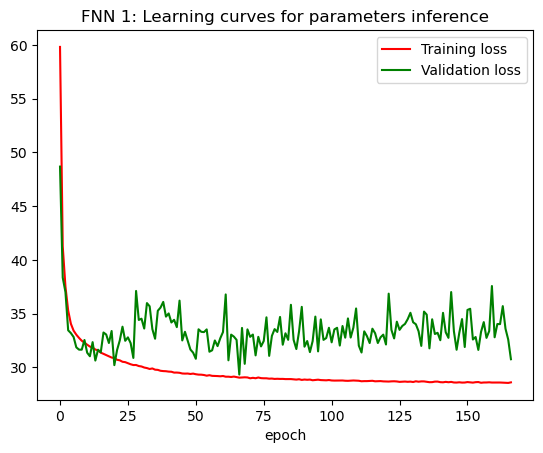

In [96]:
#----------- MODEL 1 ----------------------

# start=time.time()
# history_FNN = training(FNN_infer, batch_size=800,patience=100)
# train_duration = time.time()-start 
# print(f" Training with {train_size} training data took {train_duration/60} minutes")

# plot_curves("FNN 1", history_FNN)

In [25]:
# FNN_infer.save("FNN")

INFO:tensorflow:Assets written to: FNN/assets


Epoch 1/10000
843/843 [==============================] - 24s 28ms/step - loss: 83.5782 - val_loss: 47.9642
Epoch 2/10000
843/843 [==============================] - 22s 27ms/step - loss: 52.4275 - val_loss: 48.8572
Epoch 3/10000
843/843 [==============================] - 23s 27ms/step - loss: 48.7134 - val_loss: 49.6379
Epoch 4/10000
843/843 [==============================] - 23s 27ms/step - loss: 48.5129 - val_loss: 49.0221
Epoch 5/10000
843/843 [==============================] - 23s 27ms/step - loss: 48.3123 - val_loss: 48.6231
Epoch 6/10000
843/843 [==============================] - 23s 27ms/step - loss: 49.1176 - val_loss: 48.0915
Epoch 7/10000
843/843 [==============================] - 23s 27ms/step - loss: 49.1008 - val_loss: 46.9735
Epoch 8/10000
843/843 [==============================] - 23s 27ms/step - loss: 47.5711 - val_loss: 50.4470
Epoch 9/10000
843/843 [==============================] - 23s 27ms/step - loss: 48.6921 - val_loss: 44.7652
Epoch 10/10000
843/843 [=============

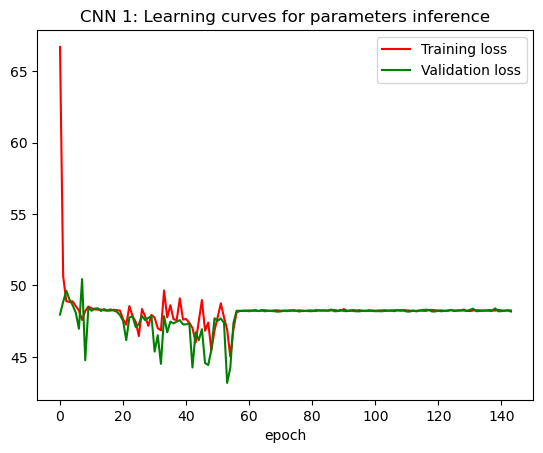

In [63]:
# #------------ OTHER MODEL ----------------------
# # Training
# start=time.time()
# history_1 = training(CNN_infer1, batch_size=400, patience=90, min_diff=1) # I should change patience
# train_duration = time.time()-start 

# print(f" Training with {train_size} training data took {train_duration/60} minutes")

# # Results
# plot_curves("CNN 1", history_1)

In [29]:
# Save the model : https://www.tensorflow.org/guide/keras/save_and_serialize

# CNN_infer1.save("CNN_1")

INFO:tensorflow:Assets written to: CNN_1/assets


Epoch 1/10000
422/422 [==============================] - 36s 82ms/step - loss: 66.6041 - val_loss: 48.7558
Epoch 2/10000
422/422 [==============================] - 34s 81ms/step - loss: 45.3517 - val_loss: 44.3074
Epoch 3/10000
422/422 [==============================] - 34s 82ms/step - loss: 43.9545 - val_loss: 44.3383
Epoch 4/10000
422/422 [==============================] - 35s 82ms/step - loss: 42.6662 - val_loss: 54.3643
Epoch 5/10000
422/422 [==============================] - 35s 83ms/step - loss: 44.3979 - val_loss: 50.0674
Epoch 6/10000
422/422 [==============================] - 35s 83ms/step - loss: 41.1817 - val_loss: 79.5259
Epoch 7/10000
422/422 [==============================] - 35s 83ms/step - loss: 42.0811 - val_loss: 53.1783
Epoch 8/10000
422/422 [==============================] - 35s 84ms/step - loss: 40.1823 - val_loss: 43.2515
Epoch 9/10000
422/422 [==============================] - 35s 84ms/step - loss: 37.1954 - val_loss: 39.3663
Epoch 10/10000
422/422 [=============

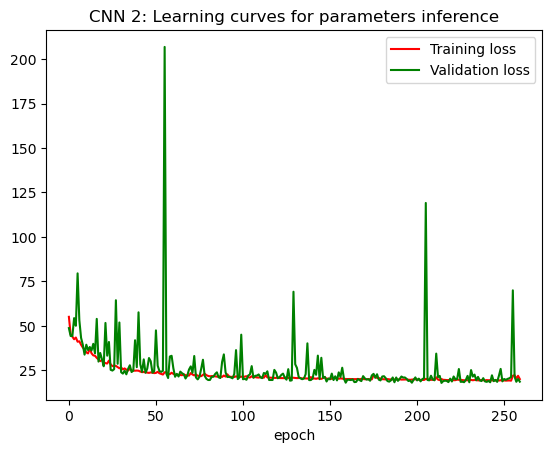

In [8]:
#------------- OTHER MODEL ---------------------

start=time.time()
history_2 = training(CNN_infer2, batch_size=800,patience=100)
train_duration = time.time()-start 
print(f" Training with {train_size} training data took {train_duration/60} minutes")

plot_curves("CNN 2", history_2)

In [10]:
# Save the model 
CNN_infer2.save("CNN_2")

INFO:tensorflow:Assets written to: CNN_2/assets


Epoch 1/800
843/843 [==============================] - 57s 64ms/step - loss: 77.2623 - val_loss: 48.5854
Epoch 2/800
843/843 [==============================] - 55s 65ms/step - loss: 50.7188 - val_loss: 49.2262
Epoch 3/800
843/843 [==============================] - 55s 65ms/step - loss: 48.9681 - val_loss: 47.7442
Epoch 4/800
843/843 [==============================] - 55s 65ms/step - loss: 48.4278 - val_loss: 47.9565
Epoch 5/800
843/843 [==============================] - 55s 65ms/step - loss: 48.1599 - val_loss: 46.9524
Epoch 6/800
843/843 [==============================] - 55s 65ms/step - loss: 47.6353 - val_loss: 46.1273
Epoch 7/800
843/843 [==============================] - 55s 65ms/step - loss: 47.3580 - val_loss: 46.3310
Epoch 8/800
843/843 [==============================] - 55s 65ms/step - loss: 47.1898 - val_loss: 46.1445
Epoch 9/800
843/843 [==============================] - 55s 65ms/step - loss: 47.1912 - val_loss: 45.0780
Epoch 10/800
843/843 [==============================] -

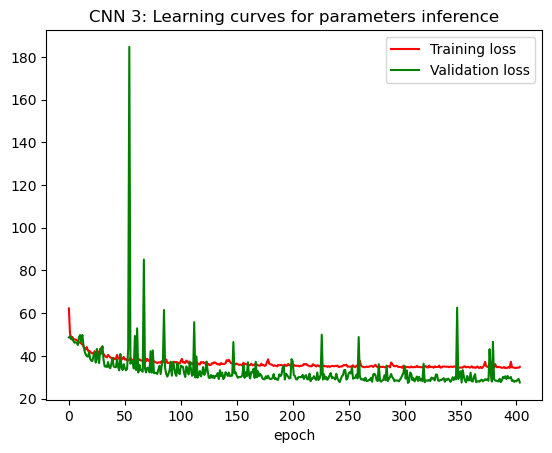

In [9]:
#------------- OTHER MODEL ---------------------

start=time.time()
history_3 = training(CNN_infer3, num_epochs=800, patience=100)
train_duration = time.time()-start 
print(f" Training with {train_size} training data took {train_duration/60} minutes")

plot_curves("CNN 3", history_3)

In [14]:
CNN_infer3.save("CNN_3")

INFO:tensorflow:Assets written to: CNN_3/assets


Epoch 1/800
843/843 [==============================] - 55s 64ms/step - loss: 89.9326 - val_loss: 48.2264
Epoch 2/800
843/843 [==============================] - 55s 65ms/step - loss: 51.0398 - val_loss: 49.5033
Epoch 3/800
843/843 [==============================] - 55s 65ms/step - loss: 51.1572 - val_loss: 47.9403
Epoch 4/800
843/843 [==============================] - 55s 65ms/step - loss: 49.4301 - val_loss: 47.2645
Epoch 5/800
843/843 [==============================] - 55s 65ms/step - loss: 48.7136 - val_loss: 47.2333
Epoch 6/800
843/843 [==============================] - 55s 65ms/step - loss: 47.9256 - val_loss: 47.3388
Epoch 7/800
843/843 [==============================] - 55s 65ms/step - loss: 47.6505 - val_loss: 47.7370
Epoch 8/800
843/843 [==============================] - 55s 65ms/step - loss: 49.0690 - val_loss: 47.4731
Epoch 9/800
843/843 [==============================] - 55s 65ms/step - loss: 47.8199 - val_loss: 46.5617
Epoch 10/800
843/843 [==============================] -

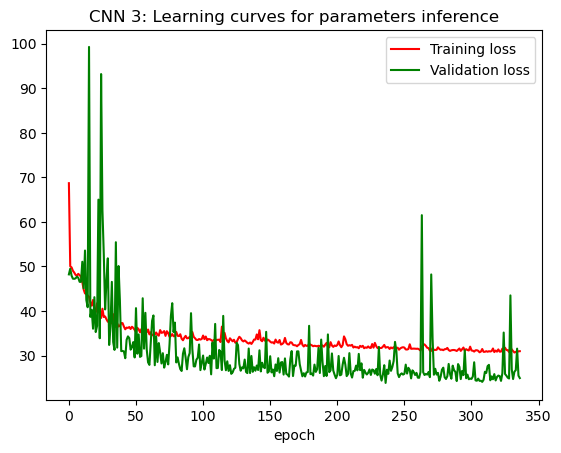

In [12]:
start=time.time()
history_4 = training(CNN_infer4, num_epochs=800, patience=100)
train_duration = time.time()-start 
print(f" Training with {train_size} training data took {train_duration/60} minutes")

plot_curves("CNN 3", history_4)

In [13]:
CNN_infer4.save("CNN_4")

INFO:tensorflow:Assets written to: CNN_4/assets


# Test

In [16]:
# load test data
params_to_infer = ["mean_signal", "amplitude", "incubation_rate", "recovery_rate", "import_param", "sampling_proba"]

test_input = np.transpose(np.load("Test/test_CBLV.npy"), axes=(0, 2, 1))
test_label = pd.read_csv("Test/test_scaled_params.csv")[params_to_infer].to_numpy()


In [15]:
# load model 
# mod_fnn = keras.models.load_model('FNN')
# mod1 = keras.models.load_model("CNN_1")
mod2 = keras.models.load_model("CNN_2")
mod3 = keras.models.load_model("CNN_3")
mod4 = keras.models.load_model("CNN_4")

In [44]:
test_input[t].shape

(901, 2)

In [17]:
t = 12
print('Predictions: \n')
# print('mod_fnn: \n', mod_fnn(test_input[t-1:t]).numpy())
# print('mod1: \n', mod1(test_input[t-1:t]).numpy())
print('mod2: \n', mod2(test_input[t-1:t]).numpy())
print('mod3: \n', mod3(test_input[t-1:t]).numpy())
print('mod4: \n', mod4(test_input[t-1:t]).numpy())

print("\n")
print('True label: \n', test_label[t-1:t])

Predictions: 

mod2: 
 [[0.5182139  3.7882364  8.750027   0.95635474 5.2396307  0.19839045]]
mod3: 
 [[0.5863105  2.939633   7.0441475  0.95010954 3.9814026  0.19802935]]
mod4: 
 [[0.5619719  3.5813622  8.087837   0.96103853 4.0729322  0.19713145]]


True label: 
 [[0.61843072 4.3384989  7.60821495 0.96401434 4.30120983 0.2       ]]


# *Mean relative error MRE*

To assess the accurary of parameter estimation, I compute the mean absolute relative error between the true parameter value (or target) and the predicted values for machine learning approaches. We used 100 simulated trees.
I choose this metric in order to compare the accurary with the one obtained in the Voznica's article.

In [77]:
def compute_error(model, inputs=test_input, labels=test_label, plot=True):
    
    RE = tf.math.abs(labels - model(inputs))/labels
    MRE = tf.reduce_mean(RE, axis=0).numpy()
    
    # PLot RE for each test tree
    if plot:
        fig = plt.figure(figsize=(10, 10))
        
        fig.add_subplot(231)
        plt.hist(RE[:,0], rwidth=0.95)
        plt.title(str(MRE[0]), fontweight='bold')
        plt.xlabel("Mean")
        
        fig.add_subplot(232)
        plt.hist(RE[:,1], rwidth=0.95)
        plt.xlabel('Amplitude')
        plt.title(str(MRE[1]), fontweight='bold')
        
        fig.add_subplot(233)
        plt.hist(RE[:,2],rwidth=0.95)
        plt.xlabel('$\sigma$')
        plt.title(str(MRE[2]), fontweight='bold')
        
        fig.add_subplot(234)
        plt.hist(RE[:,3],rwidth=0.95)
        plt.xlabel('$\gamma$')
        plt.title(str(MRE[3]), fontweight='bold')
        
        fig.add_subplot(235)
        plt.hist(RE[:,4],rwidth=0.95)
        plt.xlabel('i')
        plt.title(str(MRE[4]), fontweight='bold')
        
        fig.add_subplot(236)
        plt.hist(RE[:,5], rwidth=0.95)
        plt.xlabel("s")
        plt.title(str(MRE[5]), fontweight='bold')
        
                                  
#         plt.show()
        return fig
        
    else:
        return(RE)
#         return(MRE.numpy())

# compute_error(mod3, 'CNN_3')

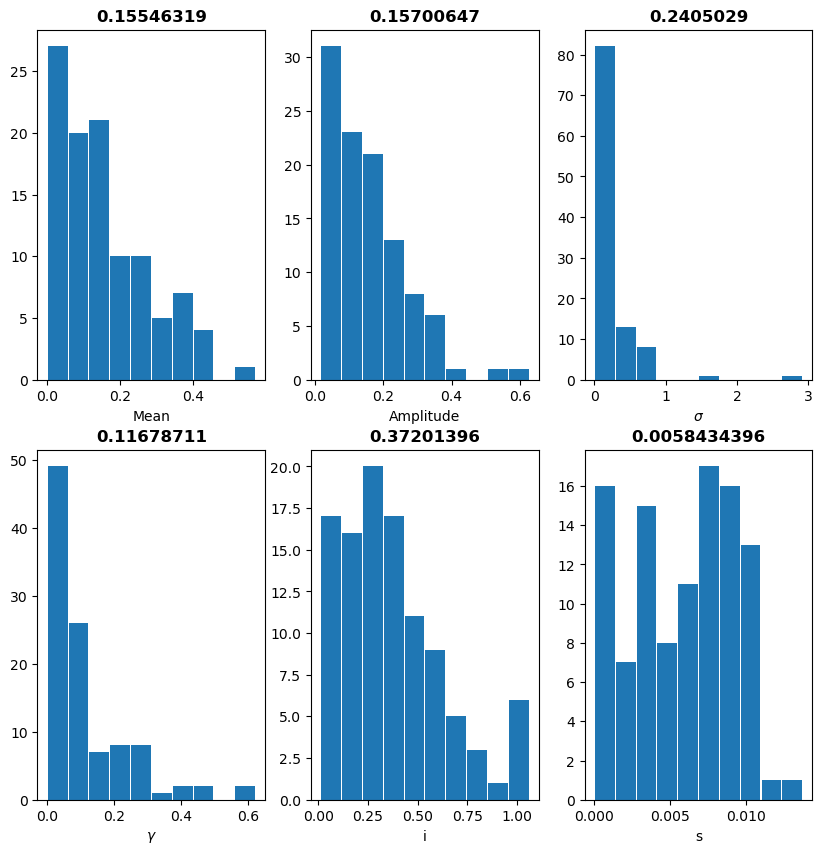

In [73]:
# compute_error(mod1)
compute_error(mod2)

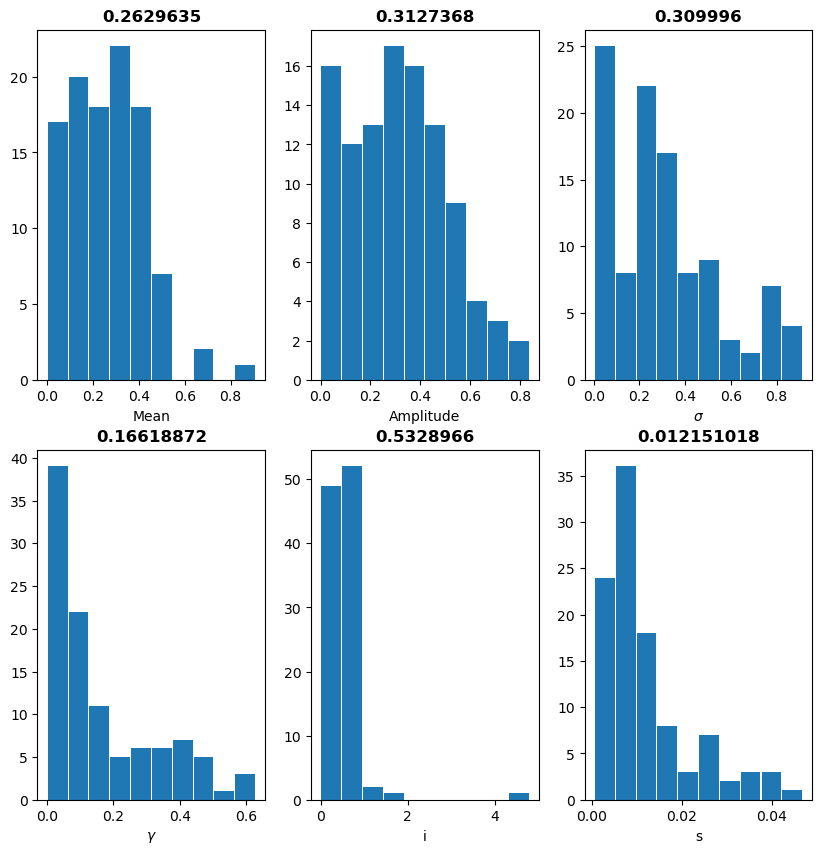

In [74]:
compute_error(mod3)

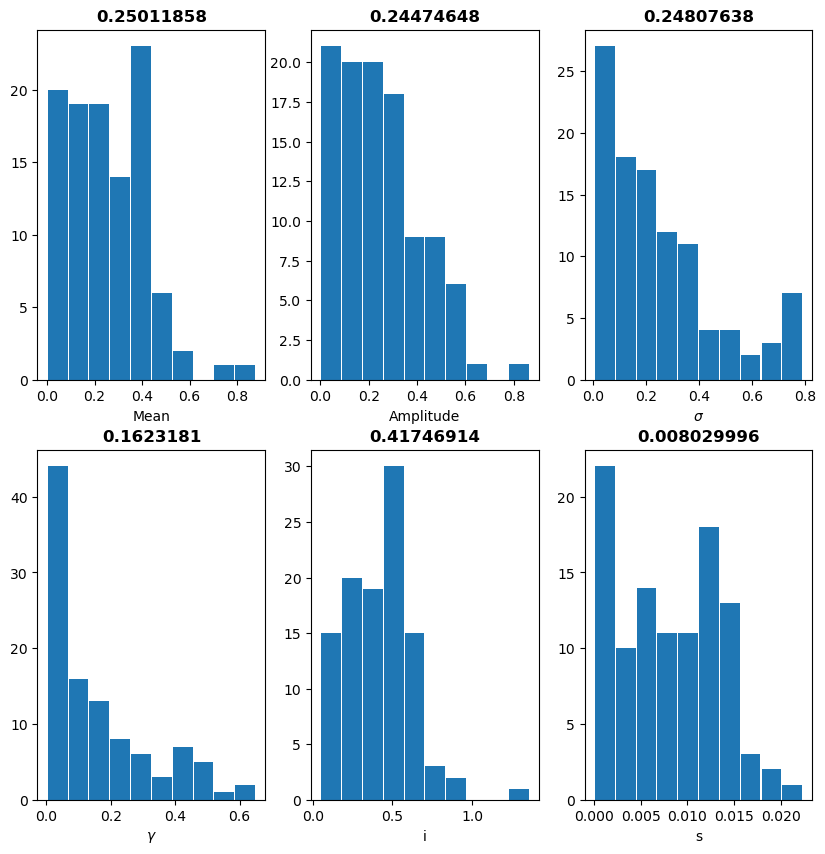

In [75]:
compute_error(mod4)

In [78]:
RE = compute_error(mod3, plot=False)
RE.shape

TensorShape([105, 6])

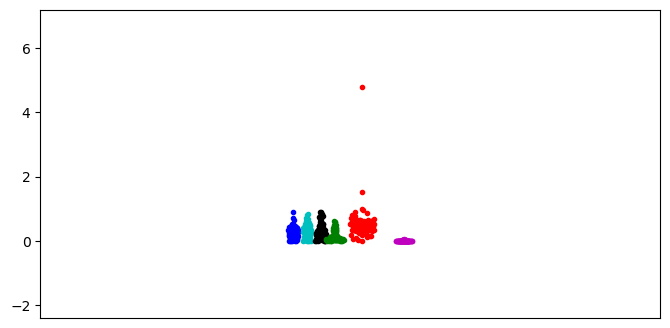

In [80]:
# Y=RE[:,0]
# c, b = np.histogram(RE[:,0])
# plt.figure(figsize=(8,4))
# for i in range(len(c)):
#     X = np.linspace(-c[i]/2, c[i]/2, c[i])
    
#     plt.plot(X, Y[(b[i] <=Y) & (Y<= b[i+1])], '.b')
    
# Y=RE[:,1]
# c, b = np.histogram(RE[:,1])
# for i in range(len(c)):
#     X = np.linspace(30-c[i]/2, 30+c[i]/2, c[i])
#     plt.plot(X, Y[(b[i] <=Y) & (Y<= b[i+1])], '.c')
    
# Y=RE[:,2]
# c, b = np.histogram(RE[:,2])
# for i in range(len(c)):
#     X = np.linspace(60-c[i]/2, 60+c[i]/2, c[i])
#     plt.plot(X, Y[(b[i] <=Y) & (Y<= b[i+1])], '.k')
    
# Y=RE[:,3]
# c, b = np.histogram(Y)
# for i in range(len(c)):
#     X = np.linspace(90-c[i]/2, 90+c[i]/2, c[i])
#     plt.plot(X, Y[(b[i] <=Y) & (Y<= b[i+1])], '.g')
    
# Y=RE[:,4]
# c, b = np.histogram(Y)
# for i in range(len(c)):
#     X = np.linspace(150-c[i]/2, 150+c[i]/2, c[i])
#     plt.plot(X, Y[(b[i] <=Y) & (Y<= b[i+1])], '.r')
    
# Y=RE[:,5]
# c, b = np.histogram(Y)
# for i in range(len(c)):
#     X = np.linspace(240-c[i]/2, 240+c[i]/2, c[i])
#     plt.plot(X, Y[(b[i] <=Y) & (Y<= b[i+1])], '.m')
    
    
    
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) 
# plt.margins(2,0.5)
# plt.show()

In [51]:
# Z = tf.gather(Y,tf.argsort(Y))
# x=list(range(0,15))*7
# plt.plot(x, Z, '.k')
# plt.margins(2,0.2)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=True,         # ticks along the top edge are off
#     labelbottom=True) 
# plt.show()

In [81]:
# fig = compute_error(mod_FNN)
# fig.savefig('Figs/err_mod_fnn.jpeg')

# fig = compute_error(mod1)
# fig.savefig('Figs/err_mod1.jpeg')

fig = compute_error(mod2)
fig.savefig('Figs/err_mod2.jpeg')

fig = compute_error(mod3)
fig.savefig('Figs/err_mod3.jpeg')

fig = compute_error(mod4)
fig.savefig('Figs/err_mod4.jpeg')

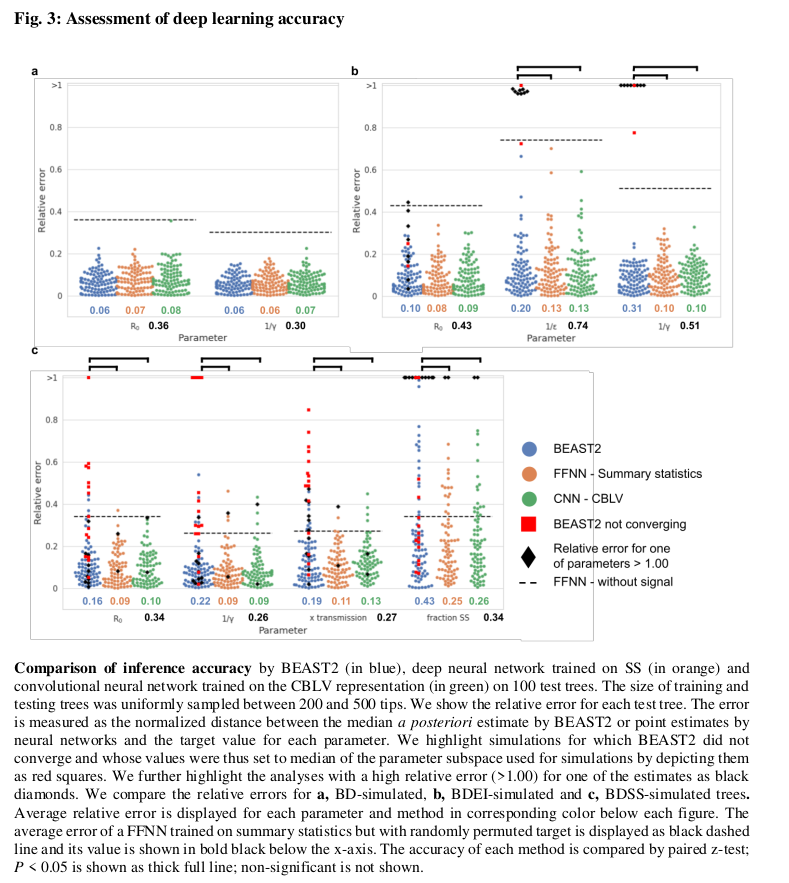

## *Relation between accuracy and tree size*

In the Voznica's article, they noticed that the accuracy of deep learning methods increaced with tree size. Let's see with our results ...

In [84]:
from sklearn.linear_model import LinearRegression

def relation_size_error(mod, param, inputs=test_input):
    
    RE = compute_error(mod, plot=False)
    X = []
    for vect in inputs:
        leaves = vect[:-1,0]
        X.append(len(leaves[leaves !=0]))
    
    Regressor = LinearRegression()
    x = np.array([X]).T
    reg = Regressor.fit(x, RE[:, param])
    sc = reg.score(x, RE[:,param])
    print('The coefficient of determination of the prediction ', sc)
    coeff = reg.coef_
    b = reg.intercept_
    
    fig = plt.figure()
    plt.plot(X, RE[:,param], '.r', label='')
    plt.plot(x, coeff*x+b, label=str(round(coeff[0],4))+'.x+'+str(round(b,2)))
    plt.xlabel('Tree size')
    plt.ylabel('Relative error')
    plt.legend()
    plt.title(params_to_infer[param]+'  $R²:$'+ str(round(sc,2)))
#     plt.title('Accuracy of deep learning method according tree size')
    plt.show()
    
    return fig

The coefficient of determination of the prediction  0.006398042125718928


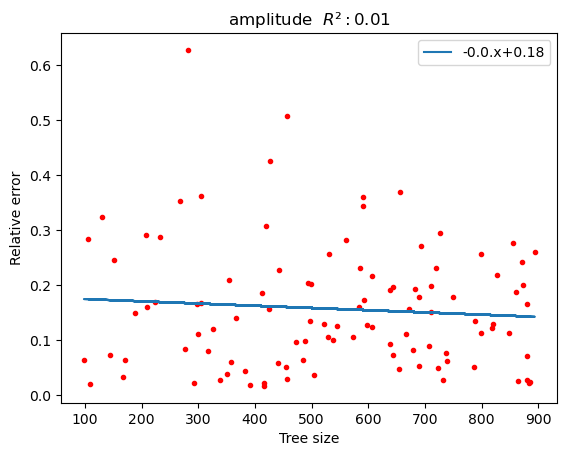

In [87]:
fig = relation_size_error(mod2, 1)

## *Comparision with null models*
To know how much and how fast neural networks learn
Null model 1 : a random predictor (https://www.tensorflow.org/tutorials/customization/custom_layers)

In [28]:
# Null model 1
class RandomPredictor(tf.keras.layers.Layer):
    def __init__(self, num_samples):
        # do all input-independent initialization
        super(RandomPredictor, self).__init__()
        self.num_samples = num_samples
        
    def build(self, input_shape):
        # where you know the shapes of the input tensors and can do the rest of the initialization
        """
        parameter_subpace : array of shape (batch_size, number of parameters, 2) containing min and max values for each parameters """
        self.num = input_shape[0]

    def call(self, parameter_subspace):
        # do the forward computation
        random_target = []
        
        for i in range(self.num):
#             random_target.append(np.random.uniform(parameter_subspace[i, 0], parameter_subspace[i, 1]))
            random_target.append(np.random.uniform(parameter_subspace[i, 0], parameter_subspace[i, 1], self.num_samples))
            
             
        return tf.transpose(tf.convert_to_tensor(random_target))
    
# TEST 
layer = RandomPredictor(2)
param = np.array([[0,1],  [45,96], [45,85]])
layer(param)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.7974764, 70.27589  , 68.872536 ], dtype=float32)>

In [ ]:
def error_random_predictor(batch_size=test_label.shape[0], labels=test_label):
    predictor = RandomPredictor(batch_size)
    # params_to_infer = ["mean_signal", "amplitude", "incubation_rate", "recovery_rate", "import_param", "sampling_proba"]
    random_out = predictor(np.array([[0.01, 0.35], [0.5,8], [0.05,1], [0.02, 0.5], [0, 10], [0.2, 0.2]]))
    RE = tf.math.abs(labels - random_out)/labels
    

In [ ]:
# Null model 2: https://www.tensorflow.org/api_docs/python/tf/random/shuffle